# **Spotify Song Recommendation System Using SEMMA Methodology**

## **Project Overview**
This analysis aims to predict song likability based on various audio features using the SEMMA (Sample, Explore, Modify, Model, and Assess) methodology. The project uses Spotify's audio features dataset to build a recommendation system that can predict whether a user will like a song based on its characteristics.

## **Data Description**
The dataset contains various audio features extracted from songs, including:

- **Danceability**: How suitable a track is for dancing (0.0 to 1.0)
- **Energy**: Perceptual measure of intensity and activity (0.0 to 1.0)
- **Loudness**: Overall loudness in decibels (dB)
- **Speechiness**: Presence of spoken words (0.0 to 1.0)
- **Acousticness**: Confidence measure of acousticness (0.0 to 1.0)
- **Instrumentalness**: Predicts whether a track contains no vocals (0.0 to 1.0)
- **Liveness**: Detects the presence of an audience (0.0 to 1.0)
- **Valence**: Musical positiveness (0.0 to 1.0)
- **Tempo**: Track's tempo in BPM
- **Target Variable**: `'liked'` (0 or 1)


In [1]:
# Kaggle API Download
# First, upload your kaggle.json API token to Colab

from google.colab import files

# Upload kaggle.json
print("Please upload your kaggle.json file:")
files.upload()

# Make directory for Kaggle and move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Spotify Recommendation dataset using Kaggle API
!kaggle datasets download -d bricevergnou/spotify-recommendation -p ./
!unzip ./spotify-recommendation.zip -d ./
print("Dataset downloaded and extracted.")


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation
License(s): CC0-1.0
  0% 0.00/29.5k [00:00<?, ?B/s]
100% 29.5k/29.5k [00:00<00:00, 41.3MB/s]
Archive:  ./spotify-recommendation.zip
  inflating: ./data.csv              
  inflating: ./dislike.json          
  inflating: ./good.json             
  inflating: ./no.py                 
  inflating: ./yes.py                
Dataset downloaded and extracted.


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
from sklearn.decomposition import PCA

# Read the dataset
print("Loading the dataset...")
df = pd.read_csv('data.csv')

Loading the dataset...



# ================ 1. SAMPLE PHASE ================

In [10]:
print("\n1. SAMPLE PHASE")
print("Original dataset shape:", df.shape)



1. SAMPLE PHASE
Original dataset shape: (195, 14)


In [11]:
# Check class balance
print("\nClass distribution:")
print(df['liked'].value_counts(normalize=True))


Class distribution:
liked
1    0.512821
0    0.487179
Name: proportion, dtype: float64


In [12]:
# Perform stratified sampling
liked = df[df['liked'] == 1]
not_liked = df[df['liked'] == 0]

In [13]:
# Take equal samples from each class
min_class_size = min(len(liked), len(not_liked))
sampled_liked = liked.sample(n=min_class_size, random_state=42)
sampled_not_liked = not_liked.sample(n=min_class_size, random_state=42)

In [14]:
# Combine samples
balanced_df = pd.concat([sampled_liked, sampled_not_liked])
print("\nBalanced dataset shape:", balanced_df.shape)


Balanced dataset shape: (190, 14)


# ================ 2. EXPLORE PHASE ================


In [19]:
print("\n2. EXPLORE PHASE")


2. EXPLORE PHASE


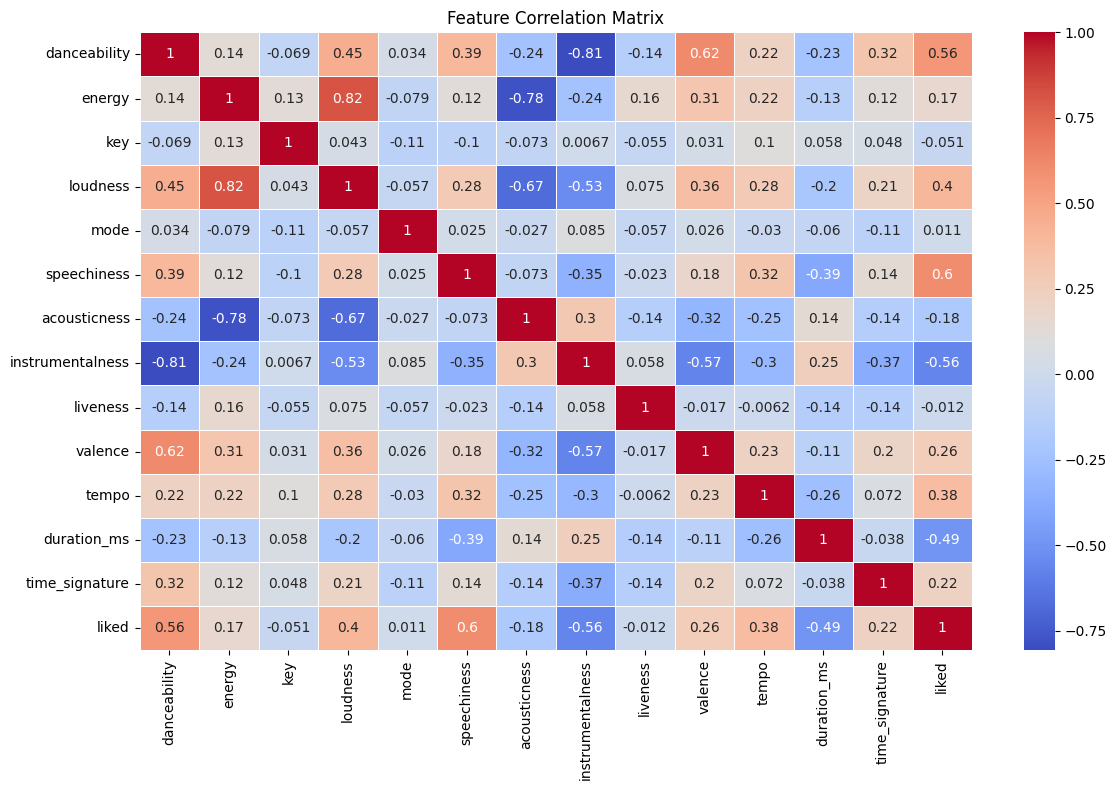

In [18]:


# Create correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = balanced_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


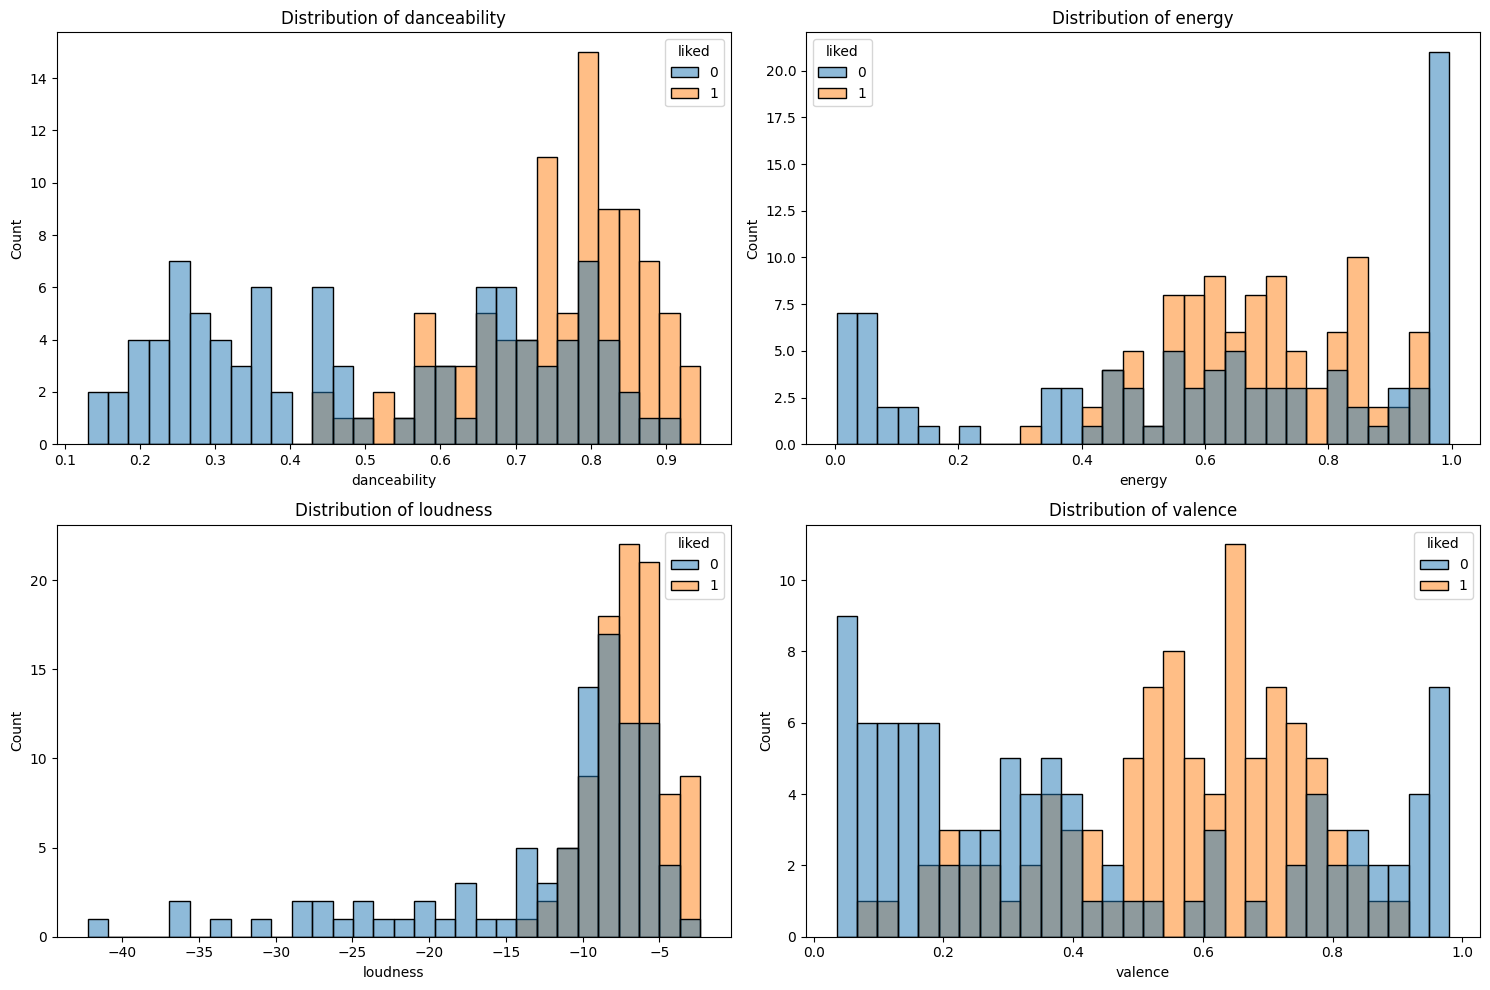

In [20]:
# Distribution of key features
features_to_plot = ['danceability', 'energy', 'loudness', 'valence']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    sns.histplot(data=balanced_df, x=feature, hue='liked', bins=30, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

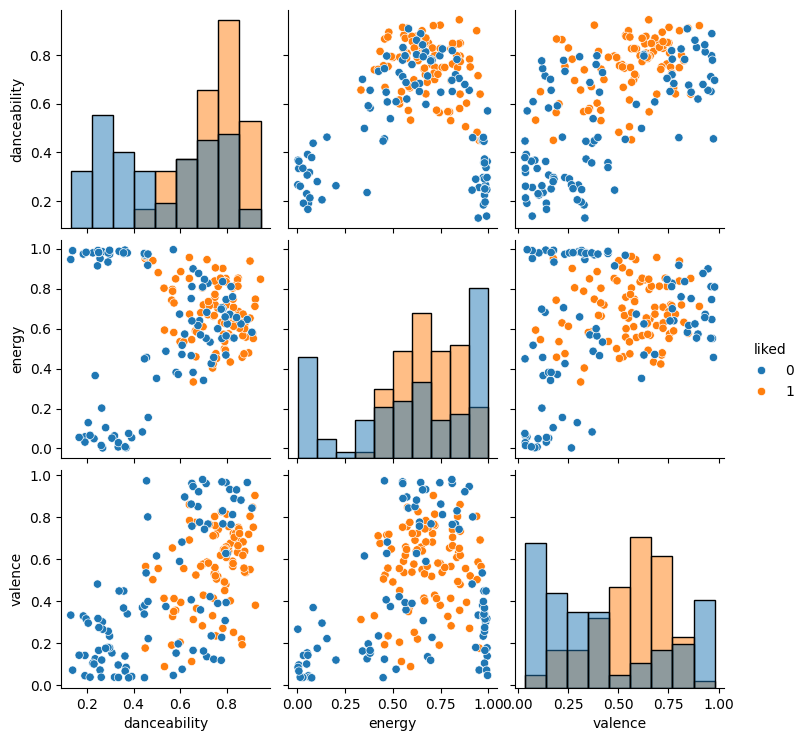

In [22]:
# Scatter plot matrix
sns.pairplot(balanced_df[['danceability', 'energy', 'valence', 'liked']],
            hue='liked', diag_kind='hist')
plt.show()



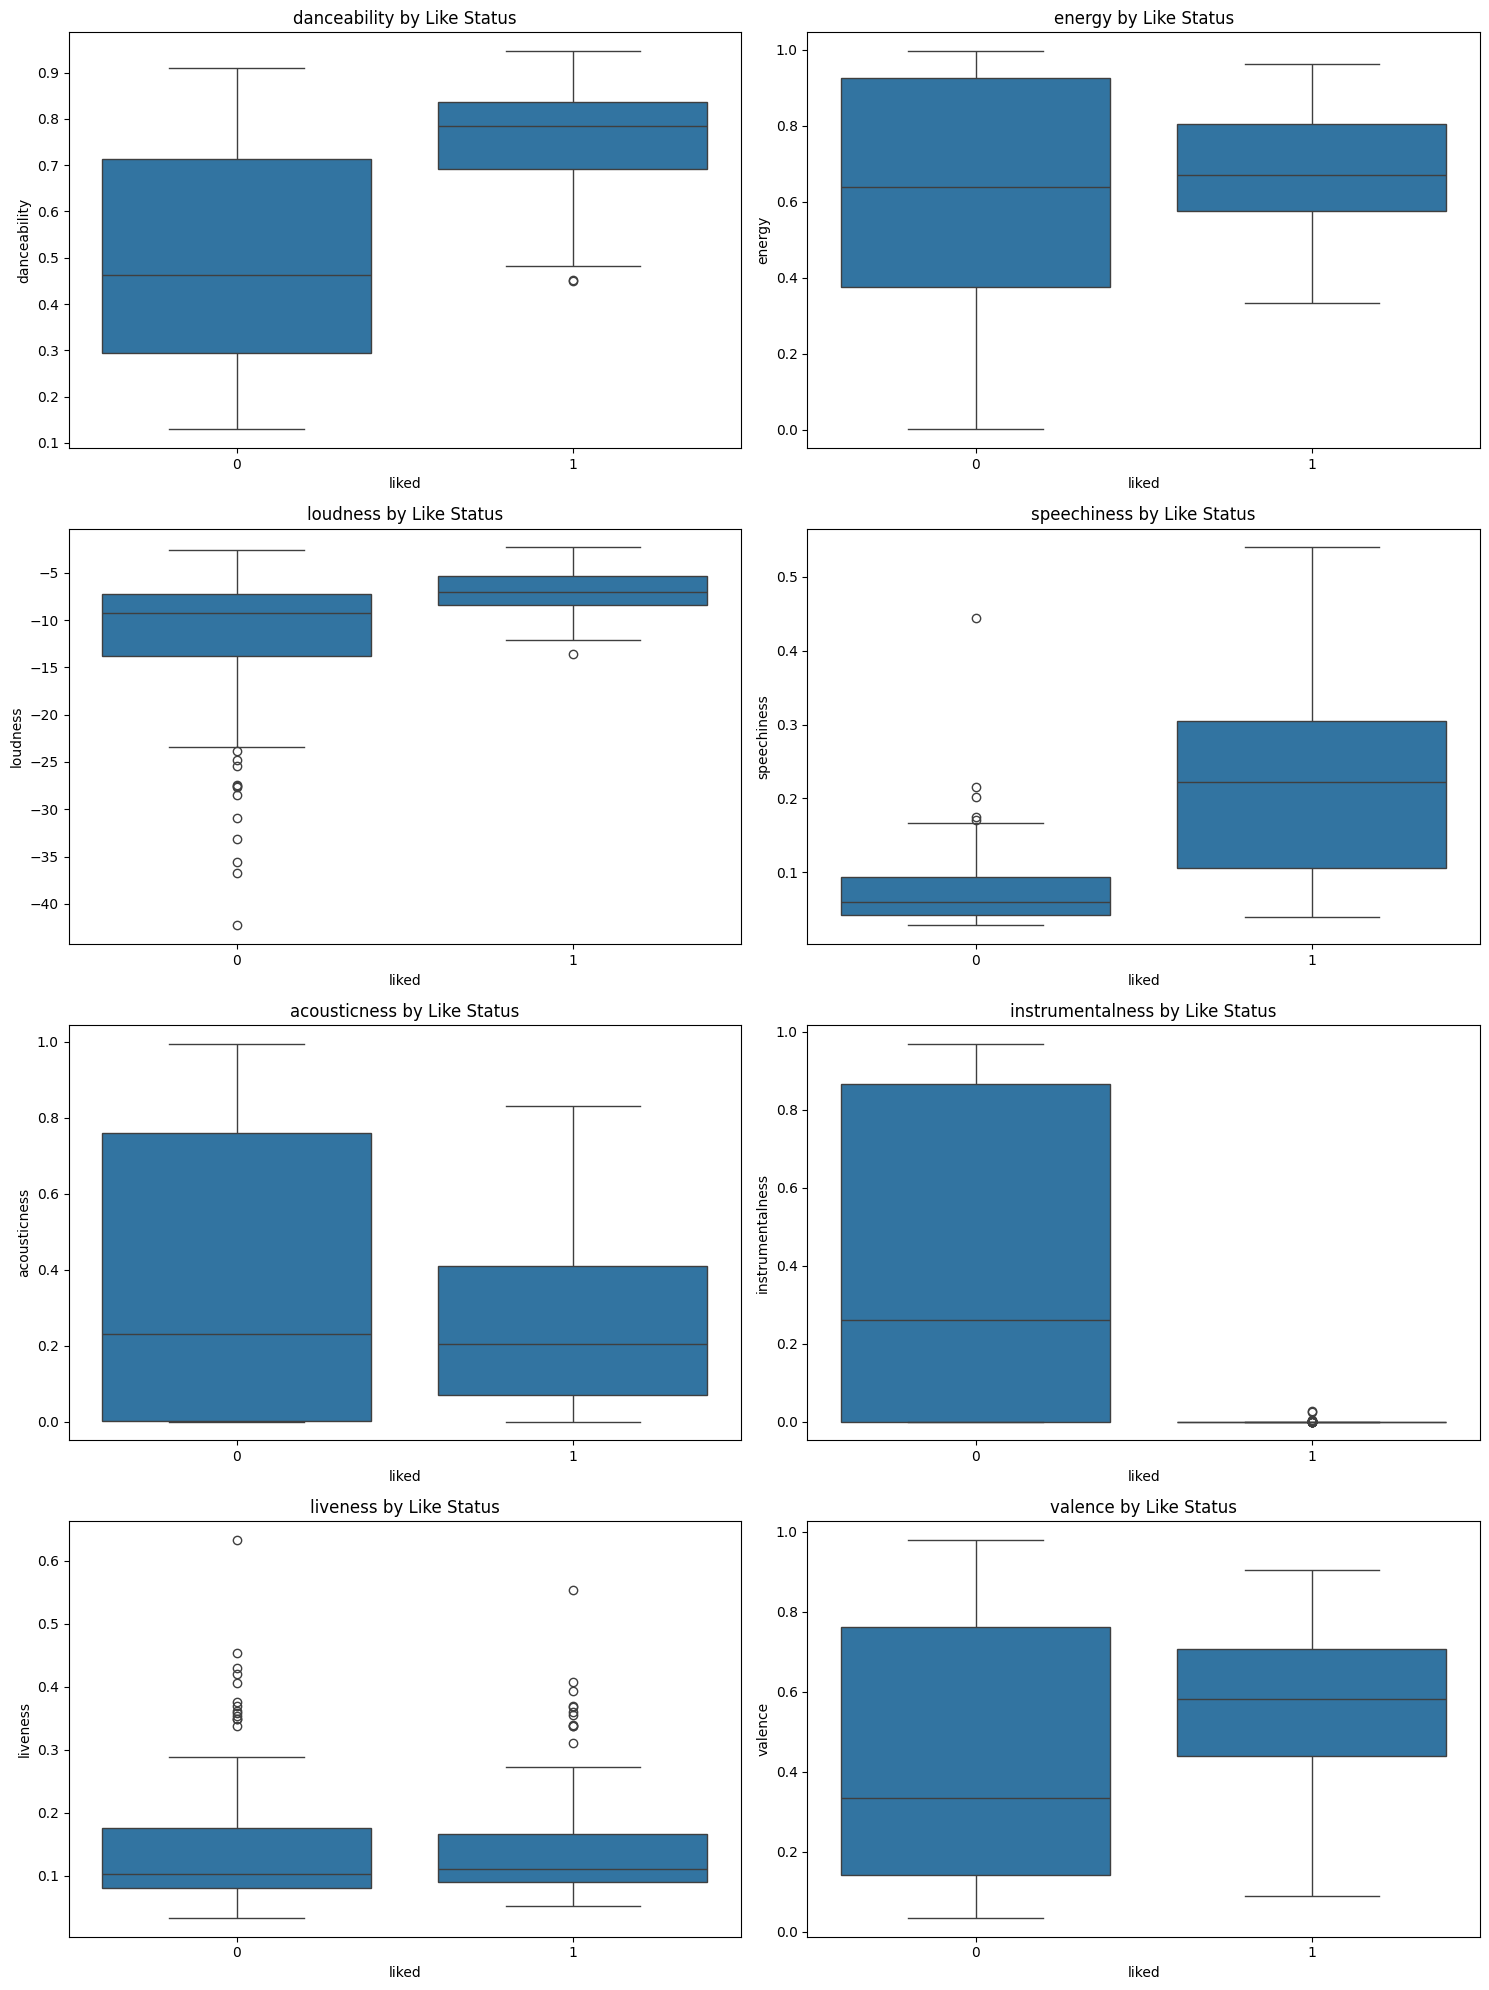

In [23]:
# Box plots
numerical_features = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence']

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    sns.boxplot(data=balanced_df, x='liked', y=feature, ax=axes[idx])
    axes[idx].set_title(f'{feature} by Like Status')

plt.tight_layout()
plt.show()

# ================ 3. MODIFY PHASE ================

In [24]:
print("\n3. MODIFY PHASE")


3. MODIFY PHASE


In [25]:
# Remove duplicates
balanced_df = balanced_df.drop_duplicates()

In [26]:
# Check missing values
print("\nMissing values:")
print(balanced_df.isnull().sum())


Missing values:
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
liked               0
dtype: int64


In [27]:
# Feature engineering
balanced_df['energy_danceability_ratio'] = balanced_df['energy'] / balanced_df['danceability']
balanced_df['loudness_energy_ratio'] = balanced_df['loudness'] / balanced_df['energy']


In [28]:
# Define features to scale
features_to_scale = ['danceability', 'energy', 'loudness', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence',
                    'tempo', 'duration_ms']


In [30]:
# Scale features
scaler = StandardScaler()
balanced_df[features_to_scale] = scaler.fit_transform(balanced_df[features_to_scale])


# ================ 4. MODEL PHASE ================

In [31]:
print("\n4. MODEL PHASE")



4. MODEL PHASE


In [32]:
# Prepare features and target
X = balanced_df[features_to_scale]
y = balanced_df['liked']

In [33]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)



Training set shape: (152, 10)
Testing set shape: (38, 10)


In [34]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
# Make predictions
y_pred = rf_model.predict(X_test)


In [36]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features_to_scale,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)


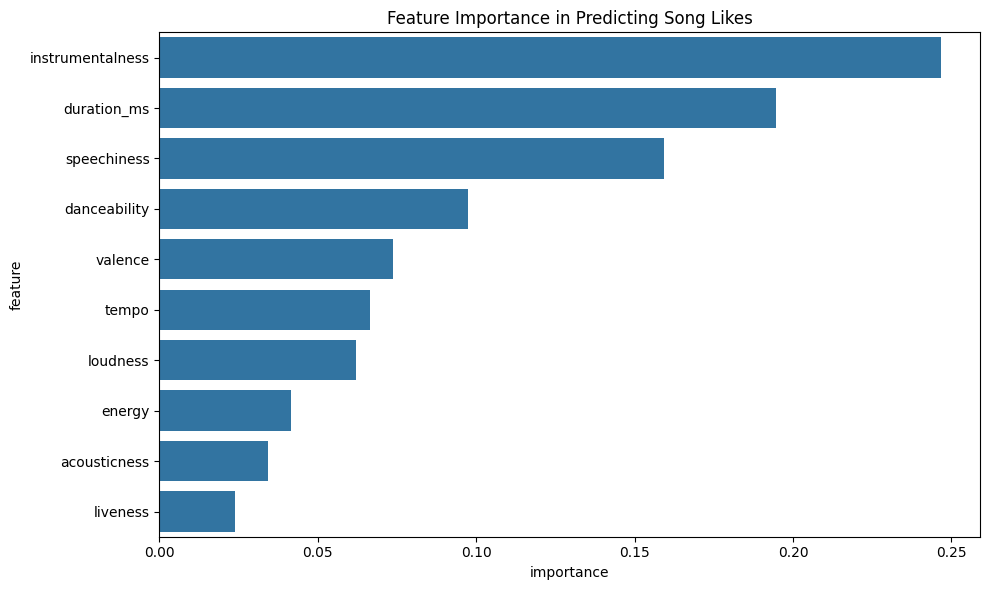

In [37]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Predicting Song Likes')
plt.tight_layout()
plt.show()

# ================ 5. ASSESS PHASE ================

In [39]:

print("\n5. ASSESS PHASE")


5. ASSESS PHASE


In [40]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.80      0.89      0.84        18

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weighted avg       0.85      0.84      0.84        38



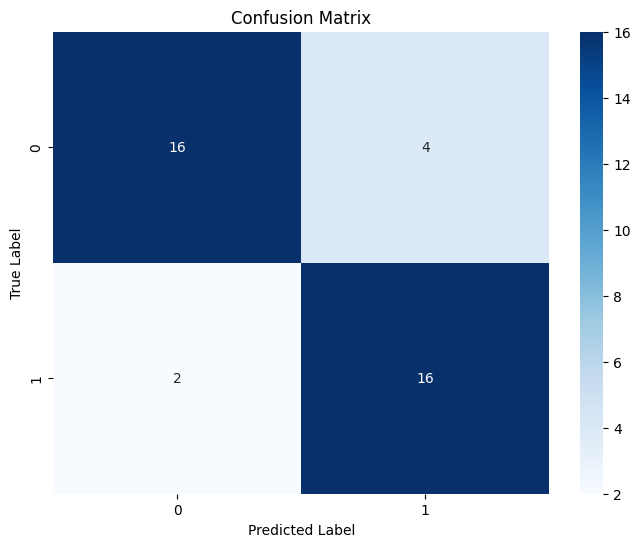

In [41]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

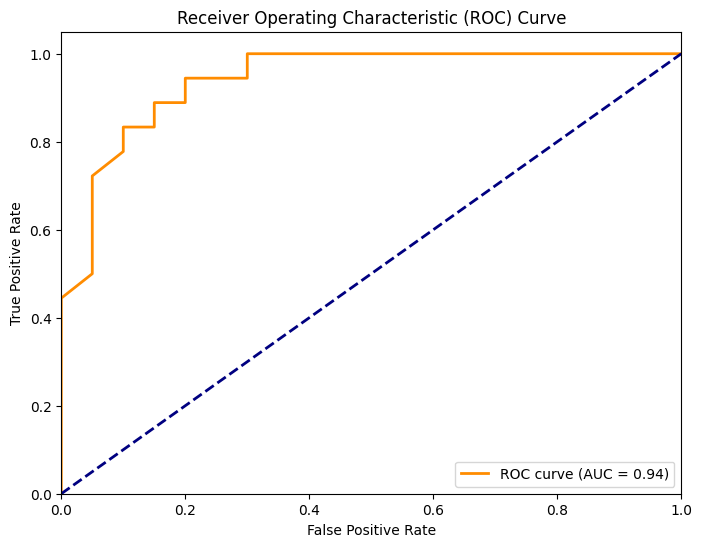

In [44]:
# Import the necessary function
from sklearn.metrics import roc_curve, auc

# ROC curve
probabilities = rf_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1]) # Now roc_curve is defined and can be used
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
# Print top features
print("\nTop 5 Most Important Features:")
print(feature_importance.head())


Top 5 Most Important Features:
            feature  importance
5  instrumentalness    0.246691
9       duration_ms    0.194489
3       speechiness    0.159319
0      danceability    0.097358
7           valence    0.073865
